# Simple Example of Sparklyr

#### Author: Greg Strabel

This notebook provides a minimal working example of fitting a model using Sparklyr. The objective is to demonstrate:
    1. Connecting to Spark with Sparklyr
    2. Reading a csv into Spark
    3. One-hot encoding categorical features
    4. Fitting a Logistic GLM with Sparklyr
    5. Using the fitted model to make predictions on test data and plot the corresponding ROC Curve

In [1]:
### Load libraries
suppressMessages({
library(sparklyr)
library(dplyr)
library(tidyr)
library(ggplot2)
})

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

### Configure Spark
conf <- spark_config()
#conf$spark.executor.memory <- "2GB"
#conf$spark.memory.fraction <- 0.9

### Start Spark
sc <- spark_connect(master = "local",
                    spark_home = "C:/spark/spark-2.3.0-bin-hadoop2.7/")

Warning message:
"package 'sparklyr' was built under R version 3.5.2"

In [2]:
#### Read csv into Spark
df <- spark_read_csv(sc = sc,
                     name = 'df',
                     path = 'BinaryClassifierData.csv')

#### Take a look at the data
df %>% head(5) %>% collect()

Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Response
A3,B7,C22,0.59602149,0.041788377,0.67362878,0
A3,B1,C27,0.06570952,0.269609522,0.88429246,0
A3,B3,C27,0.05997064,0.563043162,0.76205029,0
A0,B2,C26,0.04782884,0.289461224,0.91490289,0
A1,B7,C25,0.75214829,0.001096625,0.02597133,0


In [3]:
### One-hot encode the categorical features
df <- df %>%
  ft_string_indexer("Feature_0","Feature_0_idx") %>%
  ft_one_hot_encoder("Feature_0_idx",'Feature_0_Level') %>%
  ft_string_indexer("Feature_1","Feature_1_idx") %>%
  ft_one_hot_encoder("Feature_1_idx",'Feature_1_Level') %>%
  ft_string_indexer("Feature_2","Feature_2_idx") %>%
  ft_one_hot_encoder("Feature_2_idx",'Feature_2_Level')

In [4]:
#### Take a look at the data again
df %>% head(5) %>% collect()

Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Response,Feature_0_idx,Feature_0_Level,Feature_1_idx,Feature_1_Level,Feature_2_idx,Feature_2_Level
A3,B7,C22,0.59602149,0.041788377,0.67362878,0,0,"1, 0, 0, 0",5,"0, 0, 0, 0, 0, 1, 0",19,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
A3,B1,C27,0.06570952,0.269609522,0.88429246,0,0,"1, 0, 0, 0",0,"1, 0, 0, 0, 0, 0, 0",0,"1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
A3,B3,C27,0.05997064,0.563043162,0.76205029,0,0,"1, 0, 0, 0",1,"0, 1, 0, 0, 0, 0, 0",0,"1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
A0,B2,C26,0.04782884,0.289461224,0.91490289,0,1,"0, 1, 0, 0",2,"0, 0, 1, 0, 0, 0, 0",5,"0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
A1,B7,C25,0.75214829,0.001096625,0.02597133,0,4,"0, 0, 0, 0",5,"0, 0, 0, 0, 0, 1, 0",7,"0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"


In [5]:
#### Fit Logistic GLM
glm.model <- df %>%
  ml_generalized_linear_regression(Response ~
                                     Feature_0_Level +
                                     Feature_1_Level +
                                     Feature_2_Level +
                                     Feature_3 +
                                     Feature_4 +
                                     Feature_5,
                                   link = "logit",
                                   family = 'binomial',
                                   fit_intercept = T)

In [6]:
### Coefficients, deviance and AIC
glm.model$summary$.jobj

<jobj[173]>
  org.apache.spark.ml.regression.GeneralizedLinearRegressionTrainingSummary
  Coefficients:
            Feature Estimate Std Error  T Value P Value
        (Intercept)  -4.5179    0.4976  -9.0789  0.0000
 Feature_0_Level_A3   1.2436    0.1520   8.1819  0.0000
 Feature_0_Level_A0   1.4586    0.1538   9.4852  0.0000
 Feature_0_Level_A2   0.7020    0.1689   4.1555  0.0000
 Feature_0_Level_A4   1.0402    0.1691   6.1533  0.0000
 Feature_1_Level_B1   0.4588    0.1025   4.4759  0.0000
 Feature_1_Level_B3   0.3339    0.1087   3.0702  0.0021
 Feature_1_Level_B2   0.3909    0.1014   3.8558  0.0001
 Feature_1_Level_B6  -0.5859    0.1081  -5.4214  0.0000
 Feature_1_Level_B5   0.1774    0.1039   1.7074  0.0877
 Feature_1_Level_B7  -0.0193    0.1080  -0.1789  0.8580
 Feature_1_Level_B4  -0.2176    0.1160  -1.8767  0.0606
Feature_2_Level_C27   0.0186    0.4620   0.0403  0.9678
Feature_2_Level_C28   0.2703    0.4623   0.5846  0.5588
 Feature_2_Level_C0  -0.1807    0.4627  -0.3904  0.6962


In [7]:
### Predict on the test data
glm_predict <- sdf_predict(df,glm.model)

glm_predict <- glm_predict %>%
  dplyr::select(Response,prediction) %>%
  collect()

#quantile(glm_predict$prediction,probs = c(0:9/10,0.95,1))

### Calculate the ROC Curve
simple_roc <- function(labels, scores){
  labels <- labels[order(scores, decreasing=TRUE)]
  data.frame(TPR=cumsum(labels)/sum(labels),
             FPR=cumsum(!labels)/sum(!labels),
             labels)
}

ROC <- simple_roc(glm_predict$Response,glm_predict$prediction)

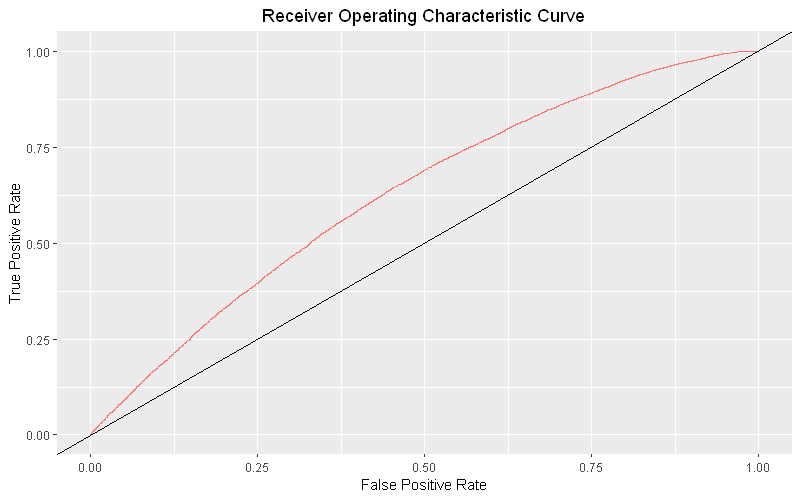

In [8]:
### Plot the ROC Curve
ggplot(ROC) +
  geom_line(aes(x=FPR,y=TPR,color="ROC")) +
  geom_abline(intercept = 0,slope = 1) +
  theme(legend.position = 'none',
        plot.title = element_text(hjust = 0.5)) +
  xlab('False Positive Rate') +
  ylab('True Positive Rate') +
  ggtitle('Receiver Operating Characteristic Curve')

In [9]:
### End spark session
spark_disconnect(sc)

NULL